# Deep template matching using LSTM in spike identification
## EE596B 2019 Spring

# Data input and processing 

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [0]:
# function to load data 
def load_data( file_feature, file_label,  normalize= True  ):
    feature =pd.read_csv( file_feature , sep=',',header=0 )        
    label =pd.read_csv( file_label, sep=',',header=0 )    
    
    if normalize:
        feature = (feature - np.min(feature))*1.0/( np.max(feature) - np.min(feature))

    label = label.values
    feature = feature.values 
    label = label.reshape( (1, -1) )[0]
    feature  = feature.reshape( (1,-1) )[0]
    
    return feature, label 

#a , b =  load_data( file_feature, file_label)

In [0]:
# function convert raw signal vector 
def get_buff_feature( feature, label, buff, batch_size = 32, spike_focus = False ):
    # feature: a vector 
    # label: a vector 
    # buff: half neighborhood window size 
    # X: N x buff size ; y: N 
    T = len(feature)    
    i = buff - 1
    y = []
    X = []
    while i + buff < T :
        i += 1
        if spike_focus and sum( label[ i - 2*buff : i + 2*buff ]) == 0:                              
            continue         
                               
        y.append( label[i]  )
        X.append(  feature[i-buff :  i + buff ] )                                

    X = np.reshape( X, (-1, buff*2) )
    y = np.array(y).reshape( (-1, 1) )
    
    N  = X.shape[0]
    num_batches = int( N / batch_size ) 
    X = X[ : num_batches * batch_size ]
    y = y[ : num_batches * batch_size ]
    
    return X, y
    


In [0]:
batch_size = 32
data_train = str(1)
buff = 200
# get training data
file_feature = 'X_test_7' + data_train + '.csv'
file_label = 'Y_test_7' + data_train  + '.csv'
feature_train, label_train = load_data( file_feature, file_label)
X_train, y_train = get_buff_feature( feature_train , label_train , buff=buff, batch_size=batch_size,  spike_focus=True )

for k in [2]:
  file_feature = 'X_test_7' + str(k) + '.csv'
  file_label = 'Y_test_7' + str(k)  + '.csv'
  feature_train, label_train = load_data( file_feature, file_label)
  X_train_k, y_train_k = get_buff_feature( feature_train , label_train , buff=buff, batch_size=batch_size,  spike_focus=True )
  X_train = np.concatenate(  (X_train, X_train_k) )
  y_train = np.concatenate(  (y_train, y_train_k) )

In [50]:
X_train.shape

(43168, 400)

# LSTM model setup 

In [0]:
# Hyperparameters 
N, window_size =  X_train.shape
batch_size = batch_size 
hidden_layer = 128 #How many units do we use in LSTM cell
clip_margin = 4 #To prevent exploding gradient, we use clipper to clip gradients below -margin or above this margin
learning_rate = 0.001
epochs = 100
num_classes  =2

In [0]:
# place holder 
inputs = tf.placeholder(tf.float32, [batch_size, window_size])
targets = tf.placeholder(tf.int32, [batch_size, 1])

In [13]:
# LSTM weights for One LSTM cell 
#Weights for the input gate
weights_input_gate = tf.Variable(tf.truncated_normal([ window_size, hidden_layer], stddev=0.05)) 
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))

#weights for the forgot gate
weights_forget_gate = tf.Variable(tf.truncated_normal([window_size, hidden_layer], stddev=0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))

#weights for the output gate
weights_output_gate = tf.Variable(tf.truncated_normal([window_size, hidden_layer], stddev=0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))

#weights for the memory cell
weights_memory_cell = tf.Variable(tf.truncated_normal([window_size, hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
## Output layer weights
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, num_classes], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([ 1 , num_classes]))

In [0]:
# one LSTM cell
def LSTM_cell(input, output, state):
    
    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)
    
    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)
    
    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)
    
    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)
    
    state = state * forget_gate + input_gate * memory_cell
    
    output = output_gate * tf.tanh(state)
    return state, output

In [0]:
# formally store object of output at each time for each of batch input 
# no calculation really conducted 

logits = []
predictions = []
batch_state = np.zeros([ 1, hidden_layer], dtype=np.float32) 
batch_output = np.zeros([ 1, hidden_layer], dtype=np.float32)
    
for i in range(batch_size): 
    
    batch_state, batch_output = LSTM_cell( tf.reshape( inputs[i], ( 1, -1) ), batch_state, batch_output)
    logit = tf.matmul(batch_output, weights_output) +  bias_output_layer
    logits.append( logit )
    predictions.append(  tf.nn.softmax( logit, name = 'prediction' ) )
    


In [0]:
logits = tf.reshape(logits, ( -1 , 2) )
predictions = tf.reshape(predictions, (-1, 2) )

In [0]:
y_one_hot = tf.one_hot( targets , num_classes )

# logits and targets for loss value 
loss = tf.nn.softmax_cross_entropy_with_logits_v2( logits=logits,labels = y_one_hot )

loss = tf.reduce_mean(loss)


In [0]:
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(learning_rate)
trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

# Training 

In [0]:
saver = tf.train.Saver( max_to_keep = 100)

In [44]:

session = tf.Session()

session.run(tf.global_variables_initializer())

for i in range(epochs):
    traind_scores = []
    traind_preds = []
    epoch_loss = []
    accuracy =  0 
    accuracy1 = 0 
    
    ii = 0
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]
        
        o, p, c, _ = session.run([logits, predictions, loss, trained_optimizer], \
                          feed_dict={inputs:X_batch, targets:y_batch}) 
        
        pred = np.argmax( p, 1)
        epoch_loss.append(c)
        traind_scores.append(o)
        traind_preds.append(pred) 
        ii += batch_size
        accuracy = accuracy + np.sum(  np.equal( pred, y_batch[:,0] ) )
        accuracy1 =accuracy1 +  np.sum(  np.equal( pred[np.where(y_batch[:,0] ==1)[0]  ] , \
                                                  y_batch[ np.where(y_batch[:,0]==1)[0], 0 ]    ) )
    
    traind_preds = np.concatenate(traind_preds)
    traind_scores = np.concatenate( traind_scores)
    accuracy = accuracy/ len(y_train)     
    accuracy1 = accuracy1/ len(y_train)

    
    if (i % 10) == 0:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)) ,\
             ' Accu: {}'.format( accuracy), ' Accu 1: {}'.format( accuracy1) )
        
    if(i % 10) == 0:
        saver.save( session,  'checkpoints/train_data'+ data_train + 'epochs' + str(i) + '.ckpt' )
    
    
saver.save( session,  'checkpoints/train_data'+ data_train + 'epochs' + str(i) + '.ckpt' )

Epoch 0/100  Current loss: 0.049646906554698944  Accu: 1336.375  Accu 1: 0.0
Epoch 10/100  Current loss: 0.029263556003570557  Accu: 1336.5625  Accu 1: 0.3125
Epoch 20/100  Current loss: 0.023329125717282295  Accu: 1337.46875  Accu 1: 2.34375
Epoch 30/100  Current loss: 0.018978429958224297  Accu: 1339.40625  Accu 1: 4.375
Epoch 40/100  Current loss: 0.014626209624111652  Accu: 1341.1875  Accu 1: 6.84375
Epoch 50/100  Current loss: 0.013222026638686657  Accu: 1341.875  Accu 1: 7.59375
Epoch 60/100  Current loss: 0.01139287929981947  Accu: 1343.46875  Accu 1: 9.03125
Epoch 70/100  Current loss: 0.008305014111101627  Accu: 1344.625  Accu 1: 9.75
Epoch 80/100  Current loss: 0.00788387656211853  Accu: 1344.625  Accu 1: 9.71875
Epoch 90/100  Current loss: 0.006973727606236935  Accu: 1345.34375  Accu 1: 10.09375


'checkpoints/train_data1epochs99.ckpt'

In [45]:
#!mkdir -p checkpoints
tf.train.get_checkpoint_state('checkpoints/')

model_checkpoint_path: "checkpoints/train_data1epochs99.ckpt"
all_model_checkpoint_paths: "checkpoints/train_data1epochs0.ckpt"
all_model_checkpoint_paths: "checkpoints/train_data1epochs10.ckpt"
all_model_checkpoint_paths: "checkpoints/train_data1epochs20.ckpt"
all_model_checkpoint_paths: "checkpoints/train_data1epochs30.ckpt"
all_model_checkpoint_paths: "checkpoints/train_data1epochs40.ckpt"
all_model_checkpoint_paths: "checkpoints/train_data1epochs50.ckpt"
all_model_checkpoint_paths: "checkpoints/train_data1epochs60.ckpt"
all_model_checkpoint_paths: "checkpoints/train_data1epochs70.ckpt"
all_model_checkpoint_paths: "checkpoints/train_data1epochs80.ckpt"
all_model_checkpoint_paths: "checkpoints/train_data1epochs90.ckpt"
all_model_checkpoint_paths: "checkpoints/train_data1epochs99.ckpt"

In [47]:
# restroe session 
saver = tf.train.Saver()
session = tf.Session()

checkpoint = 'checkpoints/train_data1epochs99.ckpt'
saver.restore(session, checkpoint)

INFO:tensorflow:Restoring parameters from checkpoints/train_data1epochs99.ckpt


# Testing

Test data: 7 Cell: 1 

All  0.9771   Sensitivity: 0.6228  Specificity:  0.9967  Correlation:  0.6578


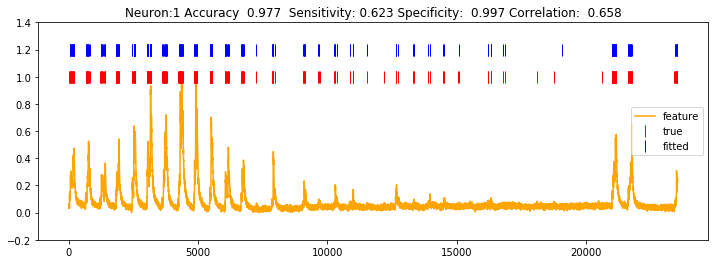

Test data: 7 Cell: 2 

All  0.9889   Sensitivity: 0.6403  Specificity:  0.9985  Correlation:  0.6761


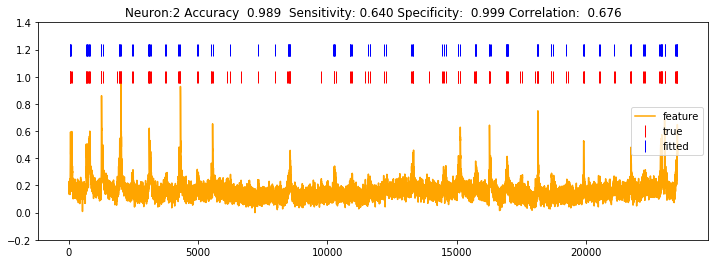

Test data: 7 Cell: 3 

All  0.9889   Sensitivity: 0.2099  Specificity:  0.9971  Correlation:  0.2605


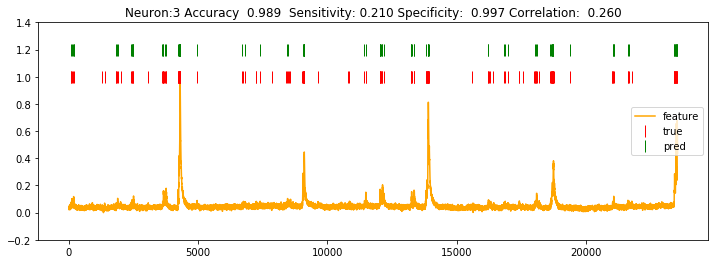

Test data: 7 Cell: 4 

All  0.9888   Sensitivity: 0.2014  Specificity:  0.9961  Correlation:  0.2153


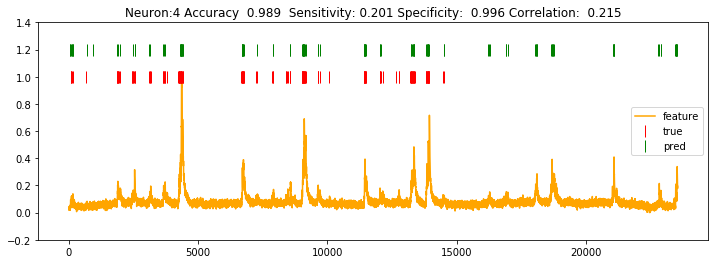

Test data: 7 Cell: 5 

All  0.9981   Sensitivity: 0.0769  Specificity:  0.9993  Correlation:  0.0891


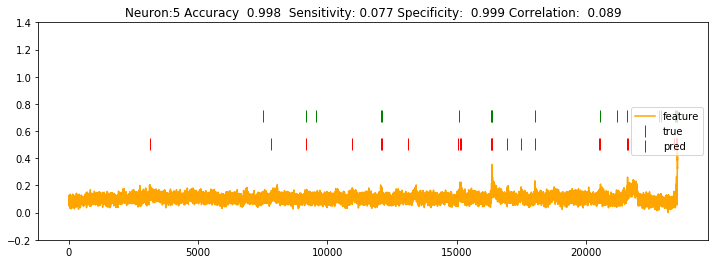

Test data: 7 Cell: 6 

All  0.9928   Sensitivity: 0.1525  Specificity:  0.9985  Correlation:  0.2251


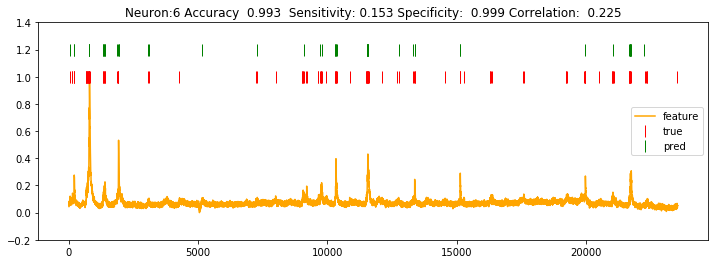

Test data: 7 Cell: 7 

All  0.9892   Sensitivity: 0.1676  Specificity:  0.9980  Correlation:  0.2519


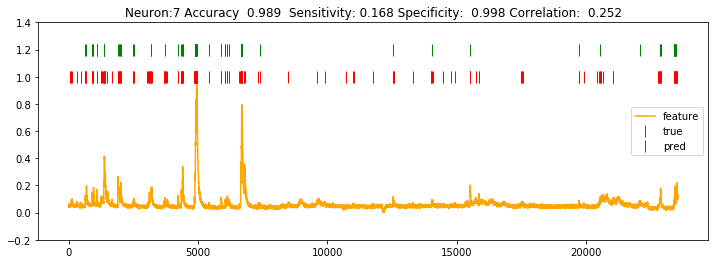

Test data: 7 Cell: 8 

All  0.9922   Sensitivity: 0.1848  Specificity:  0.9968  Correlation:  0.1816


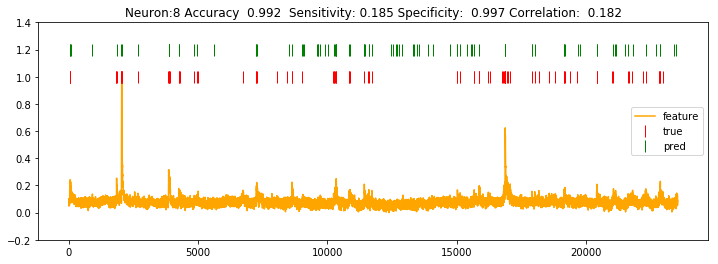

Test data: 7 Cell: 9 

All  0.9938   Sensitivity: 0.2258  Specificity:  0.9970  Correlation:  0.1904


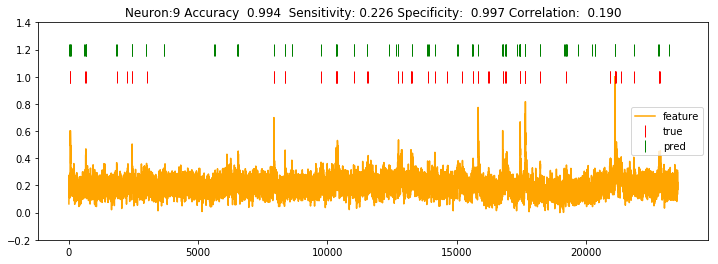

Test data: 7 Cell: 10 

All  0.9926   Sensitivity: 0.2000  Specificity:  0.9982  Correlation:  0.2596


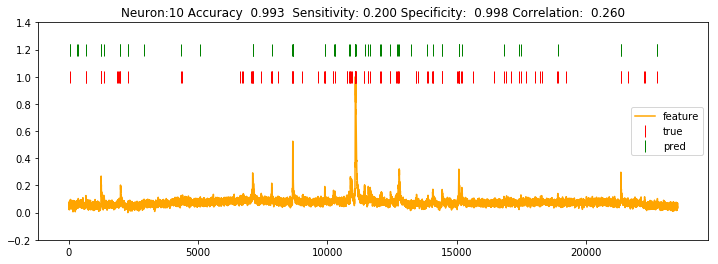

Test data: 7 Cell: 11 

All  0.9930   Sensitivity: 0.1280  Specificity:  0.9990  Correlation:  0.2241


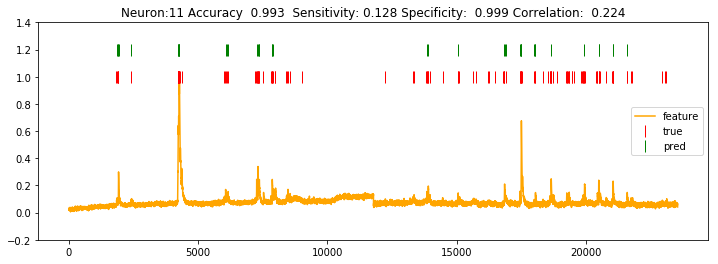

Test data: 7 Cell: 12 

All  0.9974   Sensitivity: 0.0000  Specificity:  0.9994  Correlation: -0.0011


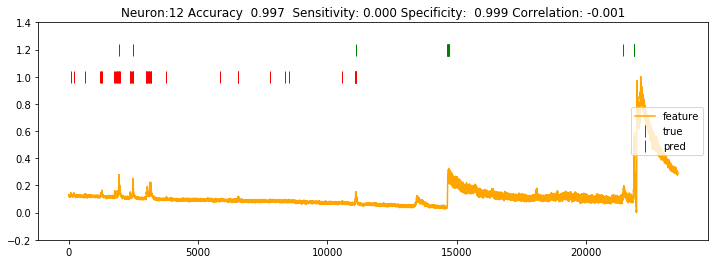

Test data: 7 Cell: 13 

All  0.9831   Sensitivity: 0.2835  Specificity:  0.9934  Correlation:  0.2676


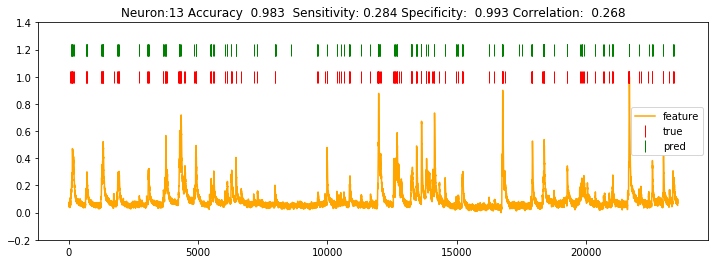

Test data: 7 Cell: 14 

All  0.9905   Sensitivity: 0.2276  Specificity:  0.9968  Correlation:  0.2464


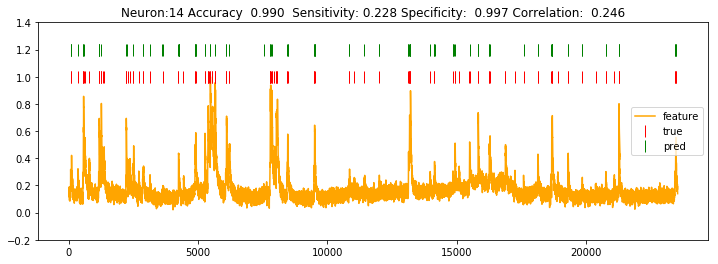

Test data: 7 Cell: 15 

All  0.9868   Sensitivity: 0.2135  Specificity:  0.9966  Correlation:  0.2643


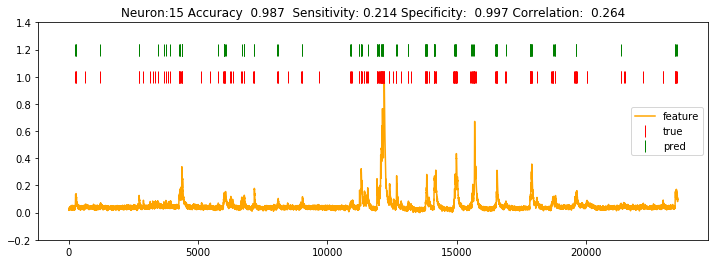

Test data: 7 Cell: 16 

All  0.9919   Sensitivity: 0.0268  Specificity:  0.9991  Correlation:  0.0658


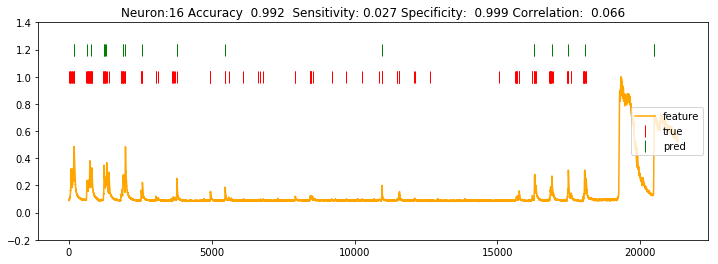

Test data: 7 Cell: 17 

All  0.9924   Sensitivity: 0.4353  Specificity:  0.9975  Correlation:  0.4095


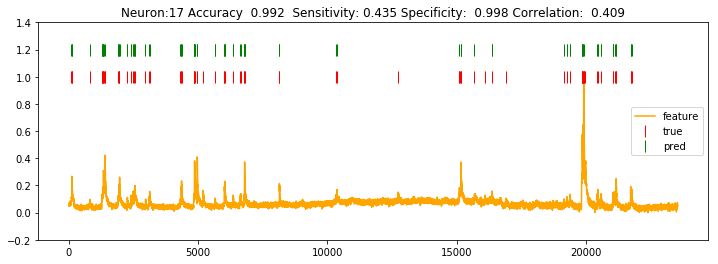

Test data: 7 Cell: 18 

All  0.9912   Sensitivity: 0.1338  Specificity:  0.9980  Correlation:  0.1930


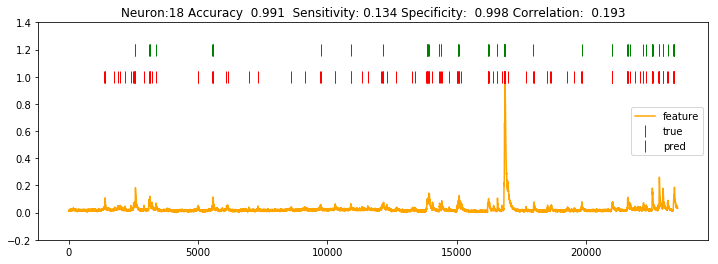

Test data: 7 Cell: 19 

All  0.9983   Sensitivity: 0.1818  Specificity:  0.9989  Correlation:  0.1133


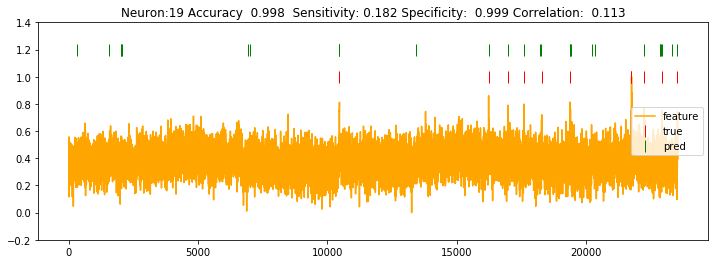

Test data: 7 Cell: 20 

All  0.9984   Sensitivity: 0.3571  Specificity:  0.9992  Correlation:  0.2781


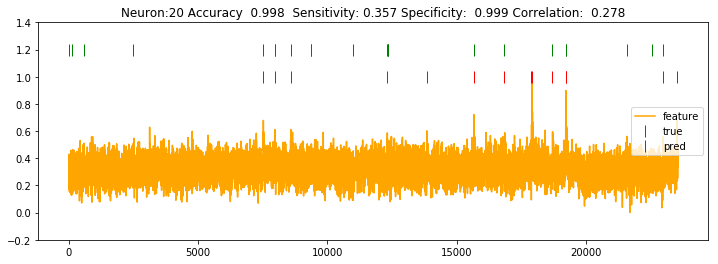

Test data: 7 Cell: 21 

All  0.9945   Sensitivity: 0.1930  Specificity:  0.9974  Correlation:  0.1683


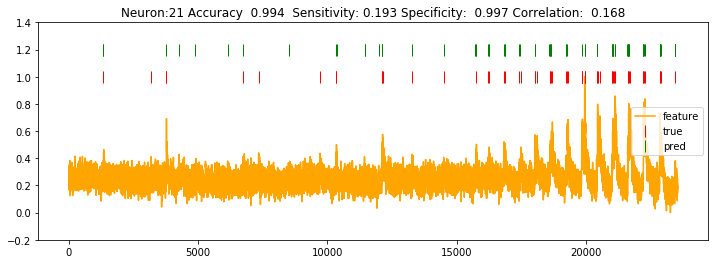

Test data: 7 Cell: 22 

All  0.9864   Sensitivity: 0.2714  Specificity:  0.9938  Correlation:  0.2322


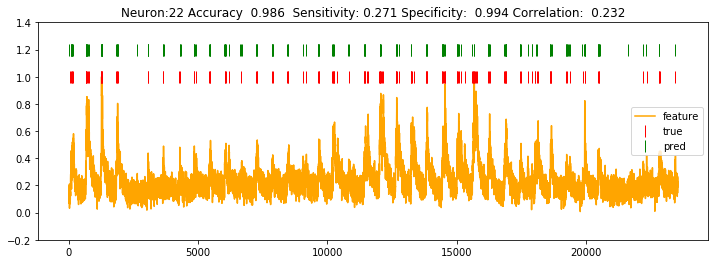

Test data: 7 Cell: 23 

All  0.9891   Sensitivity: 0.1809  Specificity:  0.9937  Correlation:  0.1319


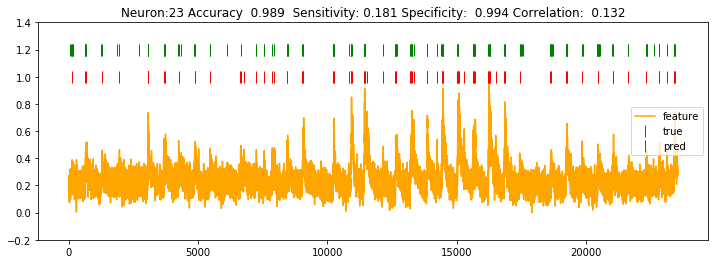

Test data: 7 Cell: 24 

All  0.9865   Sensitivity: 0.3444  Specificity:  0.9950  Correlation:  0.3209


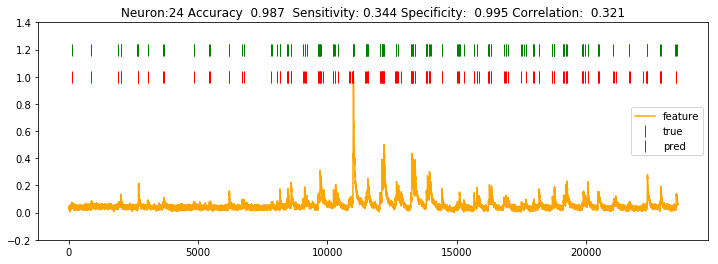

Test data: 7 Cell: 25 

All  0.9892   Sensitivity: 0.2857  Specificity:  0.9960  Correlation:  0.2785


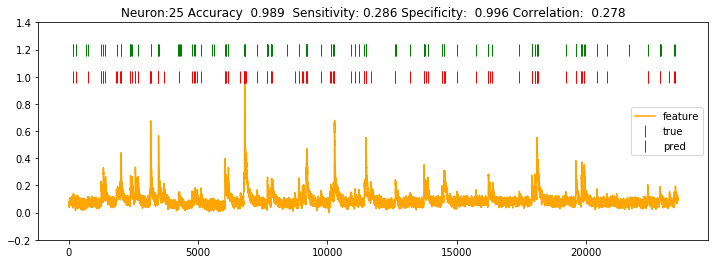

Test data: 7 Cell: 26 

All  0.9859   Sensitivity: 0.2547  Specificity:  0.9943  Correlation:  0.2396


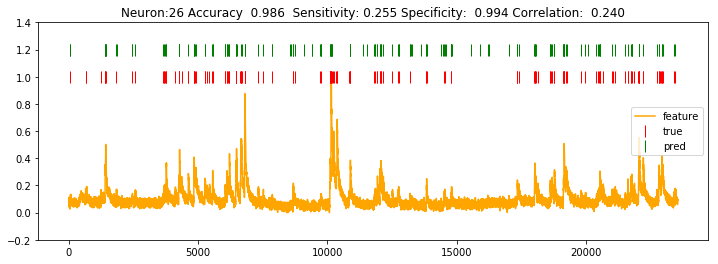

Test data: 7 Cell: 27 

All  0.9878   Sensitivity: 0.2791  Specificity:  0.9947  Correlation:  0.2468


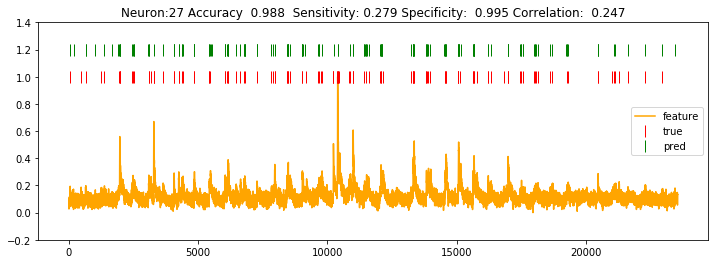

Test data: 7 Cell: 28 

All  0.9886   Sensitivity: 0.2109  Specificity:  0.9961  Correlation:  0.2271


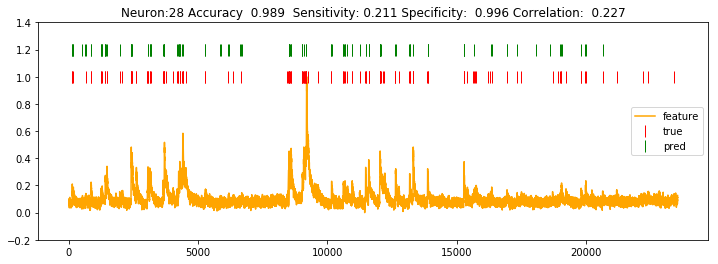

Test data: 7 Cell: 29 

All  0.9841   Sensitivity: 0.1212  Specificity:  0.9949  Correlation:  0.1453


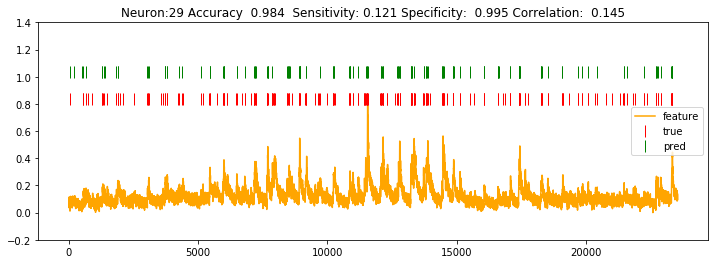

Test data: 7 Cell: 30 

All  0.9929   Sensitivity: 0.2118  Specificity:  0.9972  Correlation:  0.2102


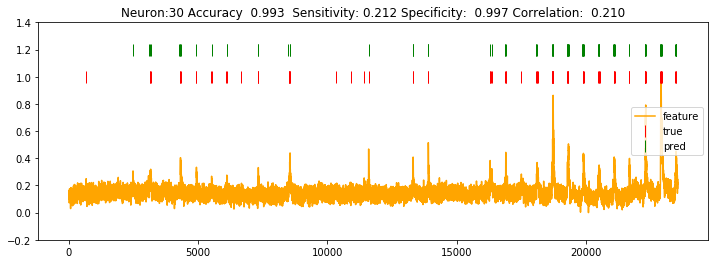

Test data: 7 Cell: 31 

All  0.9945   Sensitivity: 0.1818  Specificity:  0.9977  Correlation:  0.1809


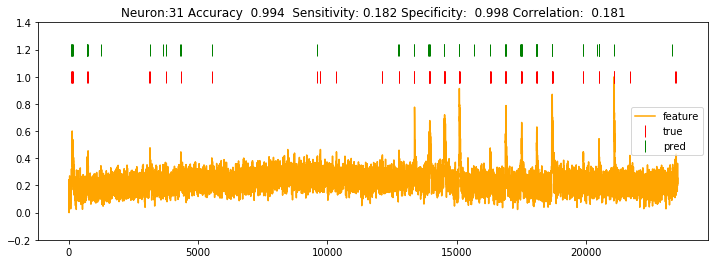

Test data: 7 Cell: 32 

All  0.9939   Sensitivity: 0.1489  Specificity:  0.9985  Correlation:  0.2019


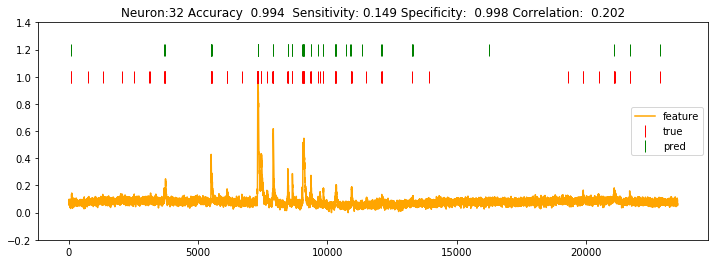

Test data: 7 Cell: 33 

All  0.9899   Sensitivity: 0.2880  Specificity:  0.9967  Correlation:  0.2994


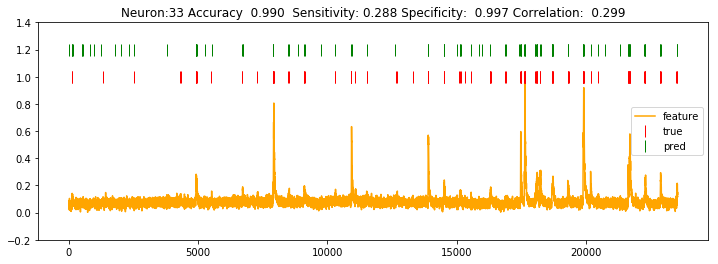

Test data: 7 Cell: 34 

All  0.9876   Sensitivity: 0.2878  Specificity:  0.9951  Correlation:  0.2689


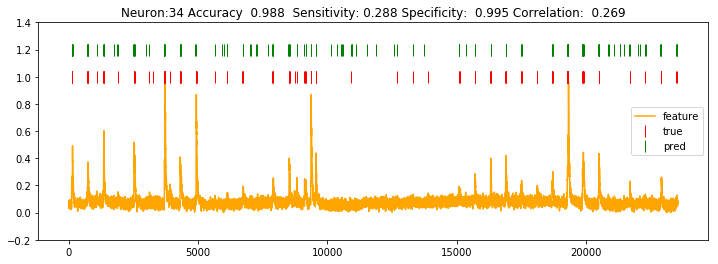

Test data: 7 Cell: 35 

All  0.9877   Sensitivity: 0.2603  Specificity:  0.9954  Correlation:  0.2557


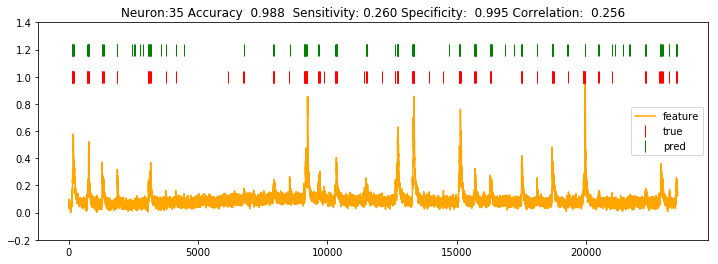

Test data: 7 Cell: 36 

All  0.9916   Sensitivity: 0.2703  Specificity:  0.9975  Correlation:  0.3006


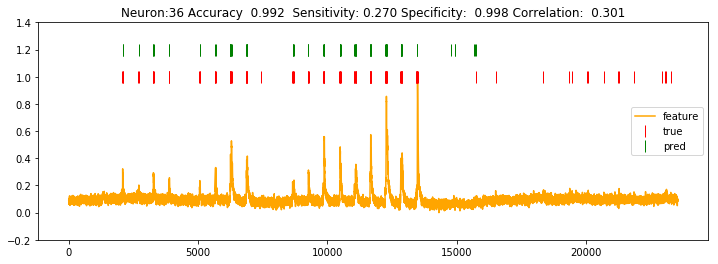

Test data: 7 Cell: 37 

All  0.9960   Sensitivity: 0.2281  Specificity:  0.9989  Correlation:  0.2779


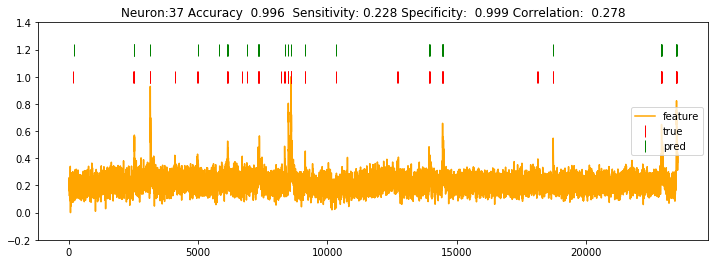

In [54]:
PRED = pd.DataFrame()
dataset = str(7)

k = 0
while k < 37:
  k= k + 1
  # predict for all cells in dataset 7 

  cell = str(k)
  file_feature_test = 'X_test_'+dataset + cell + '.csv'
  file_label_test = 'Y_test_' + dataset + cell + '.csv'
  feature_test, label_test = load_data( file_feature_test, file_label_test)
  X_test, y_test = get_buff_feature( feature_test , label_test , buff= buff, batch_size=batch_size,  spike_focus=False )

  # get prediction value 
  pred_test = []
  p_test = []
  i = 0
  while i+batch_size <= len(X_test):

      p = session.run([predictions], feed_dict={inputs:X_test[i:i+batch_size]})
      p_test.append( p  )
      pred_test.append( np.argmax( p[0], 1 ) )
      i += batch_size

  pred_test =  np.concatenate( pred_test )

  # save pred, true, feature
  pred = pd.DataFrame( {  'Dataset':  np.repeat( dataset , len(pred_test)), \
                        'Cell': np.repeat( cell , len(pred_test)), \
                       'pred' : pred_test , \
                       'true' : y_test.flatten() , \
                       'feature' :  X_test[ : , buff]
                      } )

  PRED = pd.concat(  [ PRED, pred ] )

  # calculate error measure 
  pred_all = np.mean( pred_test == y_test  ) 
  sensitivity = np.mean(  pred_test[np.where(y_test ==1)[0]  ]  ==  y_test[ np.where(y_test ==1)[0] ] )
  specificity = np.mean(  pred_test[np.where(y_test ==0)[0]  ]  ==  y_test[ np.where(y_test ==0)[0] ] )
  corr = np.corrcoef(   pred_test ,  y_test.flatten()  )[0][1]
  print( 'Test data:', dataset, 'Cell:', cell ,'\n')
  print('All {0: .{1}f} '.format( pred_all , 4), ' Sensitivity:{0: .{1}f}'.format(sensitivity,4),\
        ' Specificity: {0: .{1}f}'.format( specificity, 4) , ' Correlation: {0: .{1}f}'.format(  corr, 4)  )


    # make plot 
  feature_test = X_test[:, buff]
  label_test  = y_test[:]
  label_test_pred   = pred_test
  max_feature =   np.max( feature_test )  

  num_spikes_test = np.sum( label_test ) #true 
  pos_label_test =np.repeat(  max_feature, num_spikes_test )  # true 
  pos_time_test = np.where( label_test ==1)[0]  # true

  num_spikes_test_pred = np.sum( label_test_pred )
  pos_label_test_pred =np.repeat( max_feature +.2, num_spikes_test_pred )
  pos_time_test_pred = np.where( label_test_pred ==1)[0] 

  pos_time_test_feature = np.arange( 0 ,  len(feature_test) ) 

  # plot prediction 
  # fitted value + predicted value 
  plt.figure(figsize=(12, 4))
  plt.plot(  pos_time_test_feature ,  feature_test, label='feature', color='orange')
  plt.plot(pos_time_test , pos_label_test , '|' , color='r', markersize= 12 , label='true')
  if k <= 2:
    plt.plot(pos_time_test_pred , pos_label_test_pred , '|' , color='b', markersize= 12 ,label='fitted' )  
  else:    
    plt.plot(pos_time_test_pred , pos_label_test_pred , '|' , color='g', markersize= 12 ,label='pred' )
  plt.ylim( -0.2,  1.4)
  plt.title(  'Neuron:'+cell + ' Accuracy {0: .{1}f} '.format( pred_all , 3) + ' Sensitivity:{0: .{1}f}'.format(sensitivity,3) + \
        ' Specificity: {0: .{1}f}'.format( specificity, 3)  + ' Correlation: {0: .{1}f}'.format(  corr, 3)  )
  plt.legend(loc = 'right')
  plt.show()


In [0]:
PRED.to_csv( 'PRED_' +dataset +'_spike_focus_buff' + str(buff) + '.csv' )

In [0]:
session.close()